# Imports

In [6]:
import pandas as pd, numpy as np, ast, gc, re, math
import matplotlib, matplotlib.pyplot as plt, seaborn as sns
from tqdm.notebook import tqdm

In [7]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
from sklearn import metrics
from sklearn.manifold import TSNE   # t-SNE – algorithm to downsize of matrix

from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import category_encoders as ce

In [13]:
pd.set_option('display.max_columns', None)

# Constants and loading data

In [12]:
PATH = '/Users/irenaradzevich/Documents/sergei_dev/final project/'
TARGET, SEED = 'target', 42
np.random.seed(SEED)

In [95]:
data = pd.read_csv(PATH+'data_preprocessed.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [99]:
data.renovate = data.apply(lambda q: q.build if pd.isna(q.renovate) else q.renovate, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298953 entries, 0 to 298952
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  269296 non-null  object 
 1   private_pool            298953 non-null  int64  
 2   propertyType            298953 non-null  object 
 3   street                  298953 non-null  object 
 4   baths                   234069 non-null  object 
 5   fireplace               90149 non-null   object 
 6   city                    298949 non-null  object 
 7   sqft                    288534 non-null  object 
 8   zipcode                 298953 non-null  object 
 9   beds                    245282 non-null  object 
 10  state                   298953 non-null  object 
 11  stories                 204597 non-null  object 
 12  mls_id                  22442 non-null   object 
 13  MlsId                   263777 non-null  object 
 14  target              

# Functions

In [182]:
from sklearn.metrics import mean_absolute_error


In [11]:
def mape(y_true, y_pred):
    """
    function to calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

def smape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true))/(y_true+y_pred))*100

def mae(y_true, y_pred):
    """
    function to calculate Mean Absolute Error
    """
    return np.mean(np.abs(y_pred-y_true))

results = pd.DataFrame()
def mpl(alpha=0.5):
    """
    function to calculate Mean Pinball Loss
    :param y_true:
    :param y_pred:
    :param alpha:
    :return:
    """
    test_up = results.y_test > results.predict
    predict_up = results.y_test < results.predict
    a = results[test_up]['y_test'].sum() - results[test_up]['predict'].sum()
    b = results[predict_up]['predict'].sum() - results[predict_up]['y_test'].sum()
    mpl_value =  (alpha * a + (1 - alpha) * b) / results.shape[0]

    count_test_up = results[test_up]['y_test'].count() / results.shape[0]

    avg_under_test = a / results[test_up]['y_test'].count()
    avg_upper_test = b / results[predict_up]['y_test'].count()

    return mpl_value, 1-count_test_up, avg_under_test, avg_upper_test

In [14]:
def corr_tab(data=data, target=TARGET):
    """
    function to calculate correlation table
    :param data: dataset for analyse
    :param target: target vector in dataset
    :return: dataset of correlation values ascending from most to less
    """
    num_list = list(data.drop(target, axis=1).select_dtypes(include=['int64', 'float64']).columns)
    num_list.append(target)
    print(num_list)
    return data[num_list].corr()[target].abs().sort_values(ascending=False)

In [37]:
def name_separate(item):
    """
    function to separete text value in vector 'name' and return only first part
    :param item: text value from field of vector
    :return: first part of text value like '180 BlueEFFICIENCY 1.8 AT'
    """
    result = item.replace('(','-').replace(')','-').split('-')
    if len(result)==3:
        third = result[2]
    else:
        third = ''

    return result[0]#, result[1], third

In [38]:
def list_cut(to_cut):
    """
    function to reshape list to dataframe with several columns instead of one
    :param to_cut: list for processing
    :return: show result
    """
    # call function to separate list on baches and generate column headers for dataframe
    to_cut = list(np.sort(to_cut))
    cut_list = lambda item: [item[i:i+7] for i in range(0, len(item), 7)]
    name_list = lambda nom: ["vectors"+ str(i) for i in range(0,math.ceil(nom/7))]

    # create dataframe with data
    df_ = pd.DataFrame(cut_list(to_cut)).T
    df_.columns = name_list(len(to_cut))
    df_.fillna('', inplace=True)

    # show
    display(df_)

In [39]:
def heatmap(drop_list, dd=data, target = TARGET):
    """
    Visualise correlation by heatmap draw
    :param drop_list: list to drop from analyse
    :param dd: dataset to analyse
    :param target: target vector
    :return: show heatmap plot and list of droped columns
    """
    dlst = list(set(dd.columns) - set(drop_list) - {target})
    dlst = list(np.sort(dlst))

    dlst.append(target)
    sns.set(font_scale=1)
    plt.subplots(figsize=(16, 16))
    sns.heatmap(dd[dlst].corr(), square=True,
                annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1, vmax=1)

    list_cut(drop_list)

# Machin Learning

In [15]:
corr_tab(data)

['Unnamed: 0', 'private_pool', 'renovate', 'sqft_value', 'lot_value', 'price_value', 'baths_value', 'beds_value', 'parking_places', 'attached', 'detached', 'carport', 'build_value', 'zip', 'status_auc', 'schools_rating', 'schools_distance', 'schools_count', 'top_schools_rating', 'top_schools_distance', 'nearest_schools_rating', 'target']


target                    1.000000
top_schools_rating        0.144439
schools_rating            0.140903
nearest_schools_rating    0.138717
beds_value                0.125842
baths_value               0.124619
private_pool              0.114501
status_auc                0.040019
zip                       0.021771
price_value               0.019972
schools_count             0.017977
attached                  0.016276
carport                   0.013863
parking_places            0.012413
build_value               0.010671
schools_distance          0.010571
detached                  0.010511
Unnamed: 0                0.007266
top_schools_distance      0.007180
renovate                  0.006537
lot_value                 0.001793
sqft_value                0.000269
Name: target, dtype: float64

In [36]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298953 entries, 0 to 298952
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  269296 non-null  object 
 1   private_pool            298953 non-null  int64  
 2   propertyType            298953 non-null  object 
 3   street                  298953 non-null  object 
 4   baths                   234069 non-null  object 
 5   fireplace               90149 non-null   object 
 6   city                    298949 non-null  object 
 7   sqft                    288534 non-null  object 
 8   zipcode                 298953 non-null  object 
 9   beds                    245282 non-null  object 
 10  state                   298953 non-null  object 
 11  stories                 204597 non-null  object 
 12  mls_id                  22442 non-null   object 
 13  MlsId                   263777 non-null  object 
 14  target              

""


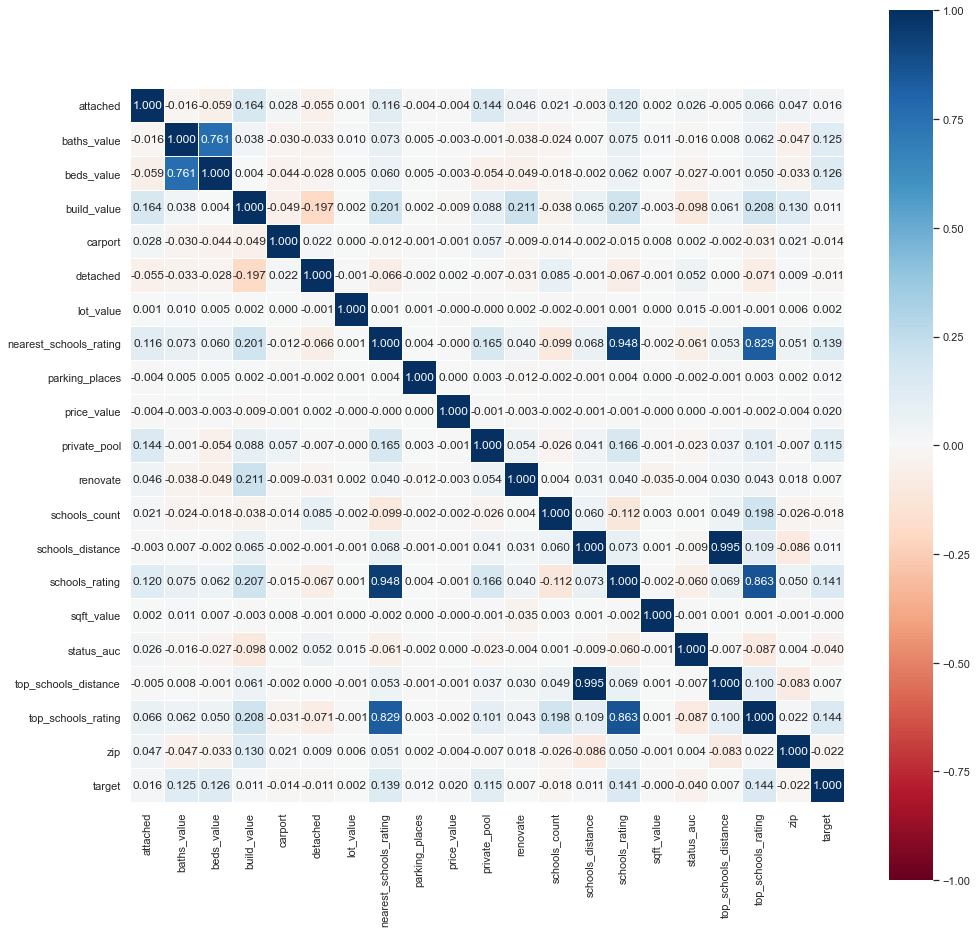

In [40]:
heatmap([])

In [100]:
x, y = data.drop([TARGET], axis=1), np.log(data[TARGET])

In [101]:
encoder=ce.TargetEncoder()
encoder.fit(x, y)
x = encoder.transform(x)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

### Catboost regressor

In [44]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = SEED,
                          #eval_metric='MAPE',
                          #custom_metric=['R2', 'MAE'],
                          #silent=True,
                          )
model.fit(x_train, y_train,
          #cat_features=cat_features_ids,
          #eval_set=(x, np.log(y_test)),
          verbose_eval=0,
          #use_best_model=True,
          #plot=True
          )

In [46]:
y_true = np.exp(y_test)
predict = np.exp(model.predict(x_test))

In [47]:
if not results.empty:
    results.drop(columns=results.columns, inplace=True)
results = x_test.copy()
results['y_test'] = np.exp(y_test)
results['predict'] = predict.astype('int64')

In [48]:
mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
mape_value, smape_value = mape(y_true, predict), smape(y_true, predict)

In [57]:
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
print(f'MAPE: {mape_value:0.2F}%')

Pinball loss  :: переоценка теста :: недооценка теста
17168.2       :: 34079.1          :: 47293.4
MAPE: 4.09%


### ExtraTrees

In [106]:
x.isna().sum()

status                    0
private_pool              0
propertyType              0
street                    0
baths                     0
fireplace                 0
city                      0
sqft                      0
zipcode                   0
beds                      0
state                     0
stories                   0
mls_id                    0
MlsId                     0
build                     0
renovate                  0
heating                   0
cooling                   0
parking                   0
lotsize                   0
price_sqft                0
sqft_value                0
lot_value                 0
price_value               0
baths_value               0
beds_value                0
parking_places            0
attached                  0
detached                  0
carport                   0
build_value               0
zip                       0
type_building             0
type_ownership            0
type_style                0
type_family         

In [105]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239162 entries, 164484 to 121958
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  239162 non-null  float64
 1   private_pool            239162 non-null  int64  
 2   propertyType            239162 non-null  float64
 3   street                  239162 non-null  float64
 4   baths                   239162 non-null  float64
 5   fireplace               239162 non-null  float64
 6   city                    239162 non-null  float64
 7   sqft                    239162 non-null  float64
 8   zipcode                 239162 non-null  float64
 9   beds                    239162 non-null  float64
 10  state                   239162 non-null  float64
 11  stories                 239162 non-null  float64
 12  mls_id                  239162 non-null  float64
 13  MlsId                   239162 non-null  float64
 14  build          

In [108]:
model = ExtraTreesRegressor(n_estimators=200, random_state=SEED)
model.fit(x_train, y_train)
y_true = np.exp(y_test)
predict = np.exp(model.predict(x_test))

In [109]:
if not results.empty:
    results.drop(columns=results.columns, inplace=True)
results = x_test.copy()
results['y_test'] = np.exp(y_test)
results['predict'] = predict.astype('int64')

In [110]:
mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
mape_value, smape_value = mape(y_true, predict), smape(y_true, predict)

In [111]:
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
print(f'MAPE: {mape_value:0.2F}%')

Pinball loss  :: переоценка теста :: недооценка теста
8348.0       :: 16609.2          :: 68079.2
MAPE: 6.42%


### GradientBoostingRegressor

In [90]:
model = GradientBoostingRegressor(n_estimators=200, random_state=SEED, loss='quantile', alpha=0.001)
model.fit(x_train.drop('renovate', axis=1), y_train)
y_true = np.exp(y_test)
predict = np.exp(model.predict(x_test.drop('renovate', axis=1)))

In [91]:
if not results.empty:
    results.drop(columns=results.columns, inplace=True)
results = x_test.copy()
results['y_test'] = np.exp(y_test)
results['predict'] = predict.astype('int64')

In [92]:
mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
mape_value, smape_value = mape(y_true, predict), smape(y_true, predict)

In [89]:
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.0f}       :: {avg_upper_test:0.0f}          :: {avg_under_test:0.0f}')
print(f'MAPE: {mape_value:0.2F}%')
# base parameters

Pinball loss  :: переоценка теста :: недооценка теста
17082       :: 34480          :: 60477
MAPE: 8.19%


In [93]:
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.0f}       :: {avg_upper_test:0.0f}          :: {avg_under_test:0.0f}')
print(f'MAPE: {mape_value:0.2F}%')
# loss='quantile' alpha=0.001

Pinball loss  :: переоценка теста :: недооценка теста
5572       :: 2744          :: 557358
MAPE: 72.90%


# Manual clustering data and ML model

#### till 500 000

In [177]:
l1 = [q*500000 for q in range(1,9)]
l2 = [q*1500000+4000000 for q in range(1,4)]

l1.extend(l2)
l1.extend([10000000, 20000000, 100000000])
l1

[500000,
 1000000,
 1500000,
 2000000,
 2500000,
 3000000,
 3500000,
 4000000,
 5500000,
 7000000,
 8500000,
 10000000,
 20000000,
 100000000]

In [186]:
metrics_result=[]
tail = 50000
for head in tqdm(l1):
    mask = (data[TARGET]>tail)&(data[TARGET]<=head)
    qtty = data[mask].shape[0]

    x = data[mask].drop([TARGET], axis=1)
    y = np.log(data[mask][TARGET])
    encoder = ce.TargetEncoder()
    encoder.fit(x, y)
    x = encoder.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

    model = CatBoostRegressor(iterations = 5000, random_seed = SEED)
    model.fit(x_train, y_train, verbose_eval=0)
    y_true = np.exp(y_test)
    predict = np.exp(model.predict(x_test))

    if not results.empty:
        results.drop(columns=results.columns, inplace=True)
    results = x_test.copy()
    results['y_test'] = np.exp(y_test)
    results['predict'] = predict.astype('int64')

    mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
    mape_value, mae_value = mape(y_true, predict), mae(y_true, predict)
    mae_s = mean_absolute_error(y_true, predict)

    values = [tail,head,qtty, mape_value, mpl_value, avg_upper_test, avg_under_test, mae_value, mae_s]
    metrics_result.append(values)

    tail = head

col = ['from', 'till', 'shape', 'MAPE', 'Pinball_Loss', 'over_pricing', 'under_pricing', 'MAE', 'MAE2']
metrics_result=pd.DataFrame(data=metrics_result, columns=col)
metrics_result[['Pinball_Loss', 'over_pricing', 'under_pricing','MAE']]=metrics_result[['Pinball_Loss', 'over_pricing', 'under_pricing','MAE']].astype(int)

  0%|          | 0/14 [00:00<?, ?it/s]

In [189]:
metrics_result.MAE2 = metrics_result.MAE2.astype(int)

In [190]:
metrics_result

,from,till,shape,MAPE,Pinball_Loss,over_pricing,under_pricing,MAE,MAE2
0,50000,500000,200293,1.839705,1758,3527,4321,392654,3926
1,500000,1000000,55854,1.062510,3432,6907,8233,757564,7575
2,1000000,1500000,13786,1.298593,7772,16029,16529,1628687,16286
3,1500000,2000000,7019,1.801105,14711,30327,32950,3168027,31680
4,2000000,2500000,3402,2.134252,23648,48917,48732,4882171,48821
5,2500000,3000000,2301,2.254068,34139,63315,61596,6252467,62524
6,3000000,3500000,1323,1.862965,31601,62527,60690,6161950,61619
7,3500000,4000000,1077,2.197400,40426,80803,85793,8329862,83298
8,4000000,5500000,1526,3.255427,69549,134346,180726,15677868,156778
9,5500000,7000000,944,3.145414,93882,206079,192465,19866031,198660


In [150]:
till, up = 50_000, 500_000
mask = (data[TARGET]>till)&(data[TARGET]<=up)
data[mask].shape

(209781, 46)

In [151]:
x = data[mask].drop([TARGET], axis=1)
y = np.log(data[mask][TARGET])
encoder = ce.TargetEncoder()
encoder.fit(x, y)
x = encoder.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

In [152]:
model = CatBoostRegressor(iterations = 5000, random_seed = SEED)
model.fit(x_train, y_train, verbose_eval=0)
y_true = np.exp(y_test)
predict = np.exp(model.predict(x_test))

if not results.empty:
    results.drop(columns=results.columns, inplace=True)
results = x_test.copy()
results['y_test'] = np.exp(y_test)
results['predict'] = predict.astype('int64')

mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
mape_value, smape_value = mape(y_true, predict), smape(y_true, predict)

print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
print(f'MAPE: {mape_value:0.2F}%')

In [125]:
results['delta'] = results.apply(lambda q: q.predict-q.y_test if q.predict>q.y_test else 0, axis=1)

In [126]:
results.sort_values(by='delta', ascending=False)

,status,private_pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls_id,MlsId,build,renovate,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value,zip,type_building,type_ownership,type_style,type_family,status_auc,schools_list,schools_rating,schools_distance,schools_count,top_schools_list,top_schools_rating,top_schools_distance,nearest_schools_rating,y_test,predict,delta
134582,12.395142,0,12.343622,12.735076,12.274509,12.363479,12.361181,12.110180,12.392784,12.343640,12.217754,12.369193,12.397647,12.392784,12.455611,12.460416,12.444704,12.375316,12.358416,12.735076,12.110349,0.0,3179880.0,0.0,50,25,2,0,0,0,1985.0,37620,12.401514,12.396363,12.357753,12.396130,0.0,12.735076,6.833333,12.850000,6.0,12.597686,8.333333,9.000000,6.666667,385000.0,766752,381752.0
174981,12.395142,0,12.293812,12.392784,12.274509,12.363479,12.162075,12.052576,12.467973,12.343640,12.379576,12.369193,12.397647,12.392784,12.455611,12.460416,12.444704,12.375316,12.358416,12.501281,12.230301,0.0,38768.0,0.0,39,25,2,0,0,0,1985.0,32226,12.401514,12.396363,12.391452,12.396130,0.0,12.456171,6.000000,3.366667,3.0,12.463399,6.000000,3.366667,6.000000,55000.0,283203,228203.0
285460,12.395142,0,12.293812,12.392784,12.274509,12.363479,12.384614,12.052576,12.196159,12.343640,12.402046,12.369193,12.397647,12.392784,12.455611,12.460416,12.444704,12.375316,12.358416,12.586985,12.230301,0.0,41382.0,0.0,42,25,2,0,0,0,1985.0,77091,12.401514,12.396363,12.391452,12.396130,0.0,12.561345,1.666667,1.266667,3.0,12.526891,1.666667,1.266667,1.666667,180000.0,402267,222267.0
294304,12.395142,0,12.313835,12.392784,12.274509,12.363479,12.406090,12.052576,12.306260,12.343640,12.379576,12.351161,12.397647,12.665399,12.281910,12.355007,12.511723,12.451879,12.358416,12.549678,12.230301,0.0,9720.0,0.0,10,15,2,0,0,0,1955.0,33169,12.401514,12.396363,12.391452,12.396130,0.0,12.771697,4.600000,12.300000,5.0,12.163375,6.666667,11.233333,4.333333,350000.0,542558,192558.0
254035,12.395142,0,12.293812,12.392784,12.274509,12.363479,12.162075,12.052576,12.467973,12.343640,12.379576,12.369193,12.397647,12.392784,12.455611,12.460416,12.444704,12.375316,12.358416,12.366807,12.230301,0.0,29621.0,0.0,30,25,2,0,0,0,1985.0,32226,12.401514,12.396363,12.391452,12.396130,0.0,12.456171,6.000000,7.533333,3.0,12.463399,6.000000,7.533333,6.000000,54900.0,239945,185045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24362,12.402169,0,12.384776,12.392784,12.301688,12.363479,12.485693,12.195322,12.557919,12.350350,12.458978,12.551898,12.397647,12.459948,12.672095,12.665594,12.444704,12.375316,12.358416,12.320187,12.530055,1432.0,3920.0,168.0,2,3,2,0,0,0,2017.0,27703,12.392708,12.396363,12.391452,12.396130,0.0,12.610255,3.333333,3.636667,3.0,12.610255,3.333333,3.636667,3.333333,239990.0,238916,0.0
221170,12.556454,0,12.420971,12.392784,12.313174,12.617873,12.698220,12.315278,12.778219,12.315276,12.691039,12.812817,12.397647,12.392784,12.289925,12.263132,12.365738,12.729996,12.364562,12.159622,12.618433,1824.0,3400.0,189.0,2,2,1,0,0,0,1978.0,80233,12.401514,12.396363,12.391452,12.396130,0.0,12.609715,2.250000,0.962500,8.0,12.609715,4.333333,0.833333,0.666667,345000.0,338950,0.0
105239,12.402169,0,12.236222,12.392784,12.110103,12.363479,12.123163,12.405082,12.436276,12.102675,11.982757,12.468005,12.392784,12.392784,12.287794,12.212057,12.414584,12.375316,12.358416,12.312259,11.874212,3362.0,7405.0,82.0,4,6,2,0,0,0,1965.0,43219,12.401514,12.396363,12.391452,12.242686,0.0,12.392784,2.500000,0.950000,2.0,12.392784,2.500000,0.950000,2.500000,275000.0,271439,0.0
266054,12.395142,0,12.406910,12.392784,12.571548,12.363479,12.673111,12.263235,12.508923,12.432849,12.217754,12.713952,12.397647,12.392784,12.274772,12.271292,12.617330,12.619206,12.603397,12.

In [ ]:
data.loc[254431]

#### till 1 000 000

In [135]:
till, up = 500_000, 1_000_000
mask = (data[TARGET]>till)&(data[TARGET]<=up)
data[mask].shape

,status,private_pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls_id,MlsId,target,build,renovate,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value,zip,type_building,type_ownership,type_style,type_family,status_auc,schools_list,schools_rating,schools_distance,schools_count,top_schools_list,top_schools_rating,top_schools_distance,nearest_schools_rating
9,for sale,0,cooperative,14205 Roosevelt Ave #512,2 baths,NaN,Flushing,"1,300 sqft",11354,3 Beds,NY,NaN,NaN,3087630,669000,1965,1965,NaN,NaN,Attached Garage,1.73 acres,$515/sqft,1300.0,75359.0,515.0,2,3,2,1,0,0,1965.0,11354,detached,cooperative,ordinal,single,0.0,"Flushing High School, Jhs 194 William Carr, Ps...",6.666667,1.516667,3.0,"Ps 193 Alfred J Kennedy, Jhs 194 William Carr,...",6.666667,1.516667,6.666667
11,for sale,1,single-family,16373 NW 16th St,3 baths,NaN,Pembroke Pines,"2,839 sqft",33028,4 Beds,FL,1.0,NaN,A10767242,525000,1996,1997.0,Forced Air,Central,"Carport, Attached Garage","10,270 sqft",$185/sqft,2839.0,10270.0,185.0,3,4,2,1,0,1,1996.0,33028,detached,private,ordinal,single,0.0,"Walter C. Young Middle School, Silver Palms El...",7.333333,2.040000,3.0,"Walter C. Young Middle School, Silver Palms El...",7.333333,2.040000,7.333333
18,for sale,1,multi-family,1633 NE 15th St,4 baths,NaN,Fort Lauderdale,"1,612 sqft",33304,4 Beds,FL,1.0,NaN,A10622323,626000,1954,1954,Forced Air,Central,NaN,"8,110 sqft",$388/sqft,1612.0,8110.0,388.0,4,4,2,0,0,0,1954.0,33304,detached,private,ordinal,multy,0.0,"Bennett Elementary School, Fort Lauderdale Hig...",5.000000,0.430000,3.0,"Fort Lauderdale High School, Sunrise Middle Sc...",5.000000,0.430000,5.000000
21,active,0,"penthouse, split-level",120 Jefferson Ave #12019,"1,000",NaN,Miami Beach,"1,080",33139,Baths,FL,Multi/Split,NaN,A10786027,579000,1996,1996.0,Central Air,Has Cooling,NaN,—,$536 / Sq. Ft.,1080.0,0.0,536.0,1,2,2,0,0,0,1996.0,33139,apartment,private,ordinal,single,0.0,"South Pointe Elementary School, Air Base Eleme...",5.000000,9.800000,5.0,"Air Base Elementary School, South Pointe Eleme...",7.000000,9.100000,5.000000
26,for sale,0,single-family,9070 Southern Orchard Rd S,3 baths,NaN,Davie,"2,349 sqft",33328,4 Beds,FL,1.0,NaN,A10782357,559000,1994,1995.0,Forced Air,Central,Attached Garage,"9,000 sqft",$238/sqft,2349.0,9000.0,238.0,3,4,2,1,0,0,1994.0,33328,detached,private,ordinal,single,0.0,"Western High School, Silver Ridge Elementary S...",8.000000,2.066667,3.0,"Western High School, Silver Ridge Elementary S...",8.000000,2.066667,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298936,for sale,0,single-family,3232 Kiesthill Dr,4 baths,yes,Dallas,"3,000 sqft",75233,4 Beds,TX,1.0,NaN,14227764,539900,1967,1967.0,Forced Air,Central,Attached Garage,0.38 acres,$180/sqft,3000.0,16553.0,180.0,4,4,2,1,0,0,1967.0,75233,detached,private,ordinal,single,0.0,"Justin F Kimball High School, T W Browne Middl...",3.000000,0.530000,3.0,"Thomas Tolbert Elementary School, T W Browne M...",3.000000,0.530000,3.000000
298946,for sale,1,single-family,1107 E Euclid Ave,NaN,NaN,San Antonio,950 sqft,78212,2 Beds,TX,1.0,NaN,1391618,799500,1938,1980.0,Wall,Central,NaN,"3,746 sqft",$842/sqft,950.0,3746.0,842.0,1,2,2,0,0,0,1938.0,78212,detached,private,ordinal,single,0.0,"Hawthorne Pk-8 Academy, Twain Middle School, E...",4.000000,1.310000,3.0,"Twain Middle School, Hawthorne Pk-8 Academy, E...",4.000000,1.310000,4.000000
298949,for sale,0,condominium,2238 11th St NW APT 2,3,NaN,Washington,"1,417",20001,2,DC,3.0,NaN,DCDC444306,799000,2010,2010,Forced air,Central,1 space,NaN,$564,1417.0,0.0,564.0,3,2,1,0,0,0,2010.0,20001,detached,condominium,ordinal,single,0.0,"Garrison Elementary School, Cardozo Education ...",3.000000,0.250000,2.0,"Garrison Elementary School, Cardozo Educatio

In [133]:
x = data[mask].drop([TARGET], axis=1)
y = np.log(data[mask][TARGET])
encoder = ce.TargetEncoder()
encoder.fit(x, y)
x = encoder.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

In [146]:
model = CatBoostRegressor(iterations = 5000, random_seed = SEED)
model.fit(x_train, y_train, verbose_eval=0)
y_true = np.exp(y_test)
predict = np.exp(model.predict(x_test))

if not results.empty:
    results.drop(columns=results.columns, inplace=True)
results = x_test.copy()
results['y_test'] = np.exp(y_test)
results['predict'] = predict.astype('int64')

mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
mape_value, smape_value = mape(y_true, predict), smape(y_true, predict)

print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
print(f'MAPE: {mape_value:0.2F}%')

Pinball loss  :: переоценка теста :: недооценка теста
470085.7       :: 1048366.1          :: 1960235.8
MAPE: 6.90%


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298953 entries, 0 to 298952
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  269296 non-null  object 
 1   private_pool            298953 non-null  int64  
 2   propertyType            298953 non-null  object 
 3   street                  298953 non-null  object 
 4   baths                   234069 non-null  object 
 5   fireplace               90149 non-null   object 
 6   city                    298949 non-null  object 
 7   sqft                    288534 non-null  object 
 8   zipcode                 298953 non-null  object 
 9   beds                    245282 non-null  object 
 10  state                   298953 non-null  object 
 11  stories                 204597 non-null  object 
 12  mls_id                  22442 non-null   object 
 13  MlsId                   263777 non-null  object 
 14  target              

# ML-clustering and ML model

Идея в том, чтобы кластеризировать объекты и применить регрессию внутри кластеров отдельно в каждом.
Для этого сделаю:
1. Превращаю записи в текст
2. "Токенизирую" текст
3. Векторизирую токены
4. Кластеризирую векторы.

In [194]:
data_copy = data.copy()

In [203]:
data = data_copy.copy()

In [205]:
data.baths.fillna('2', inplace=True)
data.beds.fillna('2', inplace=True)
data.fillna('no data', inplace=True)

In [206]:
data.isna().sum()

status                    0
private_pool              0
propertyType              0
street                    0
baths                     0
fireplace                 0
city                      0
sqft                      0
zipcode                   0
beds                      0
state                     0
stories                   0
mls_id                    0
MlsId                     0
target                    0
build                     0
renovate                  0
heating                   0
cooling                   0
parking                   0
lotsize                   0
price_sqft                0
sqft_value                0
lot_value                 0
price_value               0
baths_value               0
beds_value                0
parking_places            0
attached                  0
detached                  0
carport                   0
build_value               0
zip                       0
type_building             0
type_ownership            0
type_style          

In [208]:
x, y = data.drop(TARGET, axis=1), np.log(data[TARGET])

In [210]:
# tokenizing by encoder and standardizing by standard scaler
encoder=ce.TargetEncoder().fit(x,y)
x = encoder.transform(x)

scaler = StandardScaler().fit(x)
x = scaler.transform(x)

In [212]:
CLUSTERS = 14
kmeans = KMeans(n_clusters=CLUSTERS).fit(x)

In [216]:
# receive clusters for items
y_pred = kmeans.labels_ #.astype(int)
y_pred
data['kmeans']=y_pred

In [218]:
data.kmeans.value_counts()

3     68053
11    55771
2     54687
5     41455
1     31845
6     10477
12    10413
0      9606
9      9206
13     3805
10     3624
7         8
4         2
8         1
Name: kmeans, dtype: int64

In [219]:
# transform data to distance to centers and then transform to wight:
# nearest distance will have biggest wight
x_prob = kmeans.transform(x)
x_prob = (1 - x_prob / x_prob.sum(axis=1)[:,None])/CLUSTERS
x_prob

array([[0.07100343, 0.0711124 , 0.07113046, ..., 0.07115339, 0.07103857,
        0.07075853],
       [0.07098662, 0.07106466, 0.07115206, ..., 0.07115396, 0.07104909,
        0.07073935],
       [0.0708208 , 0.07100635, 0.07078312, ..., 0.07094708, 0.07081094,
        0.0705816 ],
       ...,
       [0.0709354 , 0.07096588, 0.07104357, ..., 0.07108738, 0.07100981,
        0.07072126],
       [0.07100921, 0.0710618 , 0.07111085, ..., 0.07117755, 0.07102516,
        0.07075393],
       [0.07095601, 0.07100699, 0.0711761 , ..., 0.07113732, 0.07103621,
        0.07073009]])

In [221]:
clu_columns = ['clu'+str(i) for i in range(CLUSTERS)]
#clu_columns = ['clu1', 'clu2', 'clu3', 'clu4', 'clu5', 'clu6', 'clu7', 'clu8', 'clu9', 'clu10', 'clu11', 'clu12', 'clu13', 'clu14']
clu_columns

['clu0',
 'clu1',
 'clu2',
 'clu3',
 'clu4',
 'clu5',
 'clu6',
 'clu7',
 'clu8',
 'clu9',
 'clu10',
 'clu11',
 'clu12',
 'clu13']

In [222]:
q_probability = pd.DataFrame(data=x_prob, columns=clu_columns)
data = pd.concat([data, q_probability], axis=1)

In [226]:
# ML regression in clusters

# dropping vectors not to encoding
x, y = data.drop([TARGET, 'kmeans', *clu_columns], axis=1), np.log(data[TARGET])

# encoding categorical features
encoder=ce.TargetEncoder().fit(x, y)
x = encoder.transform(x)

# returning vectors of kmeans cluster and target
x['kmeans'] = y_pred
x[TARGET]=y

In [231]:
# making regression in clusters and saving results in new vectors
for cluster in tqdm(set(x.kmeans)):

    if (cluster == 7)|(cluster == 8):   #skip clusters 7 and 8
        continue
    cluster_data = x[x.kmeans == cluster].copy()
    print(cluster, ": ", cluster_data.shape[0])
    cluster_x = cluster_data.drop([TARGET, 'kmeans'], axis=1)
    cluster_y = cluster_data[TARGET]

    model = CatBoostRegressor(iterations = 5000,random_seed = SEED,)
    model.fit(cluster_x, cluster_y, verbose_eval=0)

    name = f'price_{cluster}'
    data[name] = np.exp(model.predict(x))

  0%|          | 0/14 [00:00<?, ?it/s]

0 :  9606


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

1 :  31845
2 :  54687
3 :  68053
4 :  2
5 :  41455
6 :  10477
9 :  9206
10 :  3624
11 :  55771
12 :  10413
13 :  3805


In [233]:
data.isna().sum()

status          0
private_pool    0
propertyType    0
street          0
baths           0
               ..
price_9         0
price_10        0
price_11        0
price_12        0
price_13        0
Length: 74, dtype: int64

In [236]:
data.drop(['clu8'], inplace=True, axis=1)

In [234]:
def sum_prod(vec1, vec2):
    result = np.sum(np.prod([vec1, vec2], axis=0))
    return result

In [241]:
siq = [i for i in range(CLUSTERS) if i!=8]
print(siq)
clu_columns = ['clu'+str(i) for i in siq]
pr_columns = ['price_'+ str(i) for i in siq]

print(clu_columns, pr_columns)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13]
['clu0', 'clu1', 'clu2', 'clu3', 'clu4', 'clu5', 'clu6', 'clu7', 'clu9', 'clu10', 'clu11', 'clu12', 'clu13'] ['price_0', 'price_1', 'price_2', 'price_3', 'price_4', 'price_5', 'price_6', 'price_7', 'price_9', 'price_10', 'price_11', 'price_12', 'price_13']


In [245]:
item = data.loc[0]
q1, q2 = item[clu_columns].values, item[pr_columns].values
print(q1, q2)
sum_prod(q1,q2)

[0.07100342910002988 0.07111239722897904 0.07113045680049652
 0.07122889045508538 0.048286606734410445 0.07111311457579063
 0.07100988883925438 0.05776683034539509 0.07092913286517889
 0.07075079772241026 0.0711533911839455 0.07103857022729085
 0.07075852823997929] [427470.6897370068 419940.8769970117 422934.98080873233 418595.0965925403
 88213.69896009048 415703.3833992775 412041.7030786019 224066.8898928046
 409420.49922960397 394411.6804604722 412142.08676416596 545910.8332690547
 372246.03382068995]


347529.07769897854

In [246]:
data['price_sumprod'] = data.apply(lambda q: sum_prod(q[clu_columns].values, q[pr_columns].values), axis=1)
data.price_sumprod = data.price_sumprod.astype('int64')

In [250]:
# second way - take only prediction from cluster regression
data['price_kmeans']= data.apply(lambda i:
                                 (i[f'price_{i.kmeans}'])//1000*1000 if i.kmeans !=8 else i[TARGET]
                                 , axis=1).astype('int64')

In [251]:
data.sample(10).T

,32653,202613,278944,78908,218592,196475,44804,294973,185788,279389
status,for sale,active,for sale,"under contract, showing",active,active,for sale,for sale,for sale,for sale
private_pool,0,0,1,0,0,0,0,0,0,0
propertyType,single-family,no data,single-family,single-family,"condominium,townhouse,townhouse,cooperative",no data,single-family,"mobile,mobile",multi-family,single-family
street,8319 Diagonal Rd N,2721 N Pine Island Rd #112,5360 NW 106th Ct,4000 Larkspur Ln,1312 Adams St NE Apt 1,2608 Old Buena Vista Pike,307 Hibiscus Dr,27466 US Highway 19 N #48,5421 Melrose Ave,25613 Mount Rhapsody
baths,2,"1,500",2 baths,2.5,1,2,2 baths,2,4 baths,4 baths
...,...,...,...,...,...,...,...,...,...,...
price_11,94495.767517,83711.513049,474412.776543,340409.091536,332172.432305,235507.24809,225992.740521,33531.514699,841414.352801,544083.012784
price_12,192641.066403,129493.20617,613241.933241,512753.11441,503601.315614,429674.498362,294888.136842,53140.086921,1199577.327435,659891.192394
price_13,384338.763115,150843.377522,1248238.324791,943539.032016,504486.408607,375509.811718,112472.687456,149215.45166,1474843.071839,577162.162106
price_sumprod,147160,111826,437892,334774,296733,284574,188958,75438,739021,447709


In [275]:
def mpl2(predict, alpha=0.5):
    """
    function to calculate Mean Pinball Loss
    :param y_true:
    :param y_pred:
    :param alpha:
    :return:
    """
    a = np.sum([data[TARGET].values, -1*data[predict].values], axis=0)
    b = np.sum([data[predict].values, -1*data[TARGET].values], axis=0)
    a, b = np.fmax(a, np.zeros(data.shape[0])), np.fmax(b, np.zeros(data.shape[0]))
    mpl_value = np.sum(alpha*a + (1-alpha)*b)/data.shape[0]

    test_up = data[TARGET] > data[predict]
    predict_up = data[TARGET] < data[predict]
    count_test_up = data[test_up][TARGET].count() / data.shape[0]

    avg_under_test = np.sum(a) / data[test_up][TARGET].count()
    avg_upper_test = np.sum(b) / data[predict_up][TARGET].count()

    return mpl_value, 1-count_test_up, avg_under_test, avg_upper_test

In [266]:
a = np.sum([data[TARGET].values, -1*data['price_sumprod'].values], axis=0)
b = np.sum([data['price_sumprod'].values, -1*data[TARGET].values], axis=0)
a, b = np.fmax(a, np.zeros(data.shape[0])), np.fmax(b, np.zeros(data.shape[0]))
alpha = 0.01
qq = np.sum(alpha*a + (1-alpha)*b)/data.shape[0]
qq

12302.04355631153

In [277]:
mpl_value, p, avg_under_test, avg_upper_test = mpl2('price_sumprod', alpha=0.01)
mape_value, mae_value = mape(data[TARGET], data.price_sumprod), mae(data[TARGET], data.price_sumprod)

print(' ---- Sumproduct way of prediction ----')
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
#print(mpl_value, avg_upper_test, avg_under_test)
print(f'MAPE: {mape_value:0.2F}%')
print(f'MAE: {mae_value:0.0F}')

 ---- Sumproduct way of prediction ----
Pinball loss  :: переоценка теста :: недооценка теста
12302.0       :: 38929.7          :: 204668.2
MAPE: 145.32%
MAE: 15809281


In [278]:
mpl_value, p, avg_under_test, avg_upper_test = mpl2('price_kmeans', alpha=0.01)
mape_value, mae_value = mape(data[TARGET], data.price_sumprod), mae(data[TARGET], data.price_sumprod)

print(' ---- Sumproduct way of prediction ----')
print('Pinball loss  :: переоценка теста :: недооценка теста')
print(f'{mpl_value:0.1f}       :: {avg_upper_test:0.1f}          :: {avg_under_test:0.1f}')
#print(mpl_value, avg_upper_test, avg_under_test)
print(f'MAPE: {mape_value:0.2F}%')
print(f'MAE: {mae_value:0.0F}')

 ---- Sumproduct way of prediction ----
Pinball loss  :: переоценка теста :: недооценка теста
4451.3       :: 10629.8          :: 14960.6
MAPE: 145.32%
MAE: 15809281


# Tabular NN model

# Blend model results

# Production